# Loop 14 Analysis: Rotation Optimization

## Key Findings from 14 Experiments:
1. All local optimization approaches (SA, GA, fractional translation) found ZERO improvements
2. The baseline is at a TRUE local optimum
3. "Rebuild from corners" found only numerical noise improvements
4. External data sources have WORSE scores than our baseline

## New Approach: Rotation Optimization
The bbox3 runner kernel uses scipy.optimize.minimize_scalar to find optimal rotation angle for entire group.
This can tighten bounding boxes without changing tree positions.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize_scalar
import time

# Load baseline
baseline_path = '/home/nonroot/snapshots/santa-2025/21337353543/submission/submission.csv'
df = pd.read_csv(baseline_path)

# Tree polygon vertices
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

def get_tree_vertices(x, y, angle_deg):
    angle_rad = np.radians(angle_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    rx = TX * cos_a - TY * sin_a + x
    ry = TX * sin_a + TY * cos_a + y
    return rx, ry

def compute_bbox_side(trees_x, trees_y, trees_angle):
    all_x = []
    all_y = []
    for x, y, a in zip(trees_x, trees_y, trees_angle):
        vx, vy = get_tree_vertices(x, y, a)
        all_x.extend(vx)
        all_y.extend(vy)
    return max(max(all_x) - min(all_x), max(all_y) - min(all_y))

def rotate_all_trees(trees_x, trees_y, trees_angle, rotation_deg):
    """Rotate entire layout by rotation_deg degrees around centroid."""
    # Find centroid
    cx = np.mean(trees_x)
    cy = np.mean(trees_y)
    
    # Rotate positions around centroid
    angle_rad = np.radians(rotation_deg)
    cos_a = np.cos(angle_rad)
    sin_a = np.sin(angle_rad)
    
    new_x = (trees_x - cx) * cos_a - (trees_y - cy) * sin_a + cx
    new_y = (trees_x - cx) * sin_a + (trees_y - cy) * cos_a + cy
    new_angle = trees_angle + rotation_deg
    
    return new_x, new_y, new_angle

print('Functions defined. Testing on N=10...')

Functions defined. Testing on N=10...


In [2]:
# Load solutions for a specific N
def load_n(df, n):
    n_df = df[df['id'].str.startswith(f'{n:03d}_')]
    trees_x = n_df['x'].str.replace('s', '').astype(float).values
    trees_y = n_df['y'].str.replace('s', '').astype(float).values
    trees_angle = n_df['deg'].str.replace('s', '').astype(float).values
    return trees_x, trees_y, trees_angle

# Test rotation optimization on N=10
n = 10
trees_x, trees_y, trees_angle = load_n(df, n)
baseline_side = compute_bbox_side(trees_x, trees_y, trees_angle)
baseline_score = (baseline_side ** 2) / n

print(f'N={n}: Baseline side={baseline_side:.8f}, score={baseline_score:.8f}')

# Find optimal rotation
def score_at_rotation(rotation_deg):
    new_x, new_y, new_a = rotate_all_trees(trees_x, trees_y, trees_angle, rotation_deg)
    side = compute_bbox_side(new_x, new_y, new_a)
    return (side ** 2) / n

result = minimize_scalar(score_at_rotation, bounds=(-45, 45), method='bounded')
print(f'Optimal rotation: {result.x:.4f} degrees')
print(f'Optimized score: {result.fun:.8f}')
print(f'Improvement: {baseline_score - result.fun:.10f}')

N=10: Baseline side=1.94069586, score=0.37663004
Optimal rotation: 0.0000 degrees
Optimized score: 0.37663005
Improvement: -0.0000000079


In [3]:
# Test rotation optimization on multiple N values
test_ns = [5, 10, 20, 30, 50, 100, 150, 200]
results = []

for n in test_ns:
    trees_x, trees_y, trees_angle = load_n(df, n)
    baseline_side = compute_bbox_side(trees_x, trees_y, trees_angle)
    baseline_score = (baseline_side ** 2) / n
    
    def score_at_rotation(rotation_deg):
        new_x, new_y, new_a = rotate_all_trees(trees_x, trees_y, trees_angle, rotation_deg)
        side = compute_bbox_side(new_x, new_y, new_a)
        return (side ** 2) / n
    
    result = minimize_scalar(score_at_rotation, bounds=(-45, 45), method='bounded')
    improvement = baseline_score - result.fun
    
    results.append({
        'n': n,
        'baseline_score': baseline_score,
        'optimized_score': result.fun,
        'optimal_rotation': result.x,
        'improvement': improvement
    })
    
    if improvement > 1e-8:
        print(f'N={n}: IMPROVED by {improvement:.10f} (rotation={result.x:.4f}°)')
    else:
        print(f'N={n}: No improvement (rotation={result.x:.4f}°)')

print(f'\nTotal improvement: {sum(r["improvement"] for r in results):.10f}')

N=5: No improvement (rotation=-0.0000°)
N=10: No improvement (rotation=0.0000°)
N=20: No improvement (rotation=-0.0000°)
N=30: No improvement (rotation=-0.0000°)
N=50: No improvement (rotation=0.0000°)
N=100: IMPROVED by 0.0000000555 (rotation=-0.0000°)
N=150: No improvement (rotation=-0.0000°)
N=200: No improvement (rotation=0.0000°)

Total improvement: 0.0000000086


In [4]:
# Check ALL N values for rotation optimization
print('Testing rotation optimization on ALL N values (1-200)...')
start_time = time.time()

all_results = []
improvements = []

for n in range(1, 201):
    trees_x, trees_y, trees_angle = load_n(df, n)
    baseline_side = compute_bbox_side(trees_x, trees_y, trees_angle)
    baseline_score = (baseline_side ** 2) / n
    
    def score_at_rotation(rotation_deg):
        new_x, new_y, new_a = rotate_all_trees(trees_x, trees_y, trees_angle, rotation_deg)
        side = compute_bbox_side(new_x, new_y, new_a)
        return (side ** 2) / n
    
    result = minimize_scalar(score_at_rotation, bounds=(-45, 45), method='bounded')
    improvement = baseline_score - result.fun
    
    all_results.append({
        'n': n,
        'baseline_score': baseline_score,
        'optimized_score': result.fun,
        'optimal_rotation': result.x,
        'improvement': improvement
    })
    
    if improvement > 1e-8:
        improvements.append((n, improvement, result.x))

elapsed = time.time() - start_time
print(f'\nCompleted in {elapsed:.2f}s')
print(f'N values with improvements: {len(improvements)}')
print(f'Total improvement: {sum(r["improvement"] for r in all_results):.10f}')

if improvements:
    print('\nTop 10 improvements:')
    improvements.sort(key=lambda x: -x[1])
    for n, imp, rot in improvements[:10]:
        print(f'  N={n}: +{imp:.10f} (rotation={rot:.4f}°)')

Testing rotation optimization on ALL N values (1-200)...



Completed in 5.64s
N values with improvements: 50
Total improvement: 0.0000174878

Top 10 improvements:
  N=89: +0.0000069049 (rotation=0.0045°)
  N=65: +0.0000015745 (rotation=0.0010°)
  N=36: +0.0000015677 (rotation=-0.0002°)
  N=15: +0.0000011293 (rotation=-0.0005°)
  N=52: +0.0000005527 (rotation=-0.0003°)
  N=135: +0.0000005279 (rotation=0.0001°)
  N=151: +0.0000004541 (rotation=0.0004°)
  N=94: +0.0000004483 (rotation=-0.0000°)
  N=59: +0.0000004414 (rotation=0.0002°)
  N=57: +0.0000003821 (rotation=0.0002°)


In [5]:
# Let's analyze the theoretical lower bound and see how far we are from it
# The theoretical minimum is when trees are packed at maximum density

# Tree area calculation
from shapely.geometry import Polygon

tree_vertices = [
    (0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25), (0.35, 0),
    (0.075, 0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0), (-0.35, 0),
    (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]
tree_poly = Polygon(tree_vertices)
tree_area = tree_poly.area
print(f"Tree area: {tree_area:.6f}")

# For N trees, minimum possible area is N * tree_area (if perfect packing)
# But trees can't pack perfectly, so there's always some waste

# Theoretical lower bound for score
# If we could pack N trees in a square of side S, then S^2 >= N * tree_area
# So S >= sqrt(N * tree_area)
# Score = S^2 / N >= tree_area

print(f"\nTheoretical lower bound for score (per N): {tree_area:.6f}")
print(f"This assumes perfect packing with 0% waste")

# Compare with baseline
baseline_total = sum(r['baseline_score'] for r in all_results)
theoretical_total = tree_area * 200  # Sum of tree_area for N=1 to 200

print(f"\nBaseline total score: {baseline_total:.6f}")
print(f"Theoretical minimum (perfect packing): {theoretical_total:.6f}")
print(f"Gap from theoretical: {baseline_total - theoretical_total:.6f} ({(baseline_total/theoretical_total - 1)*100:.2f}%)")

Tree area: 0.245625

Theoretical lower bound for score (per N): 0.245625
This assumes perfect packing with 0% waste

Baseline total score: 70.615107
Theoretical minimum (perfect packing): 49.125000
Gap from theoretical: 21.490107 (43.75%)


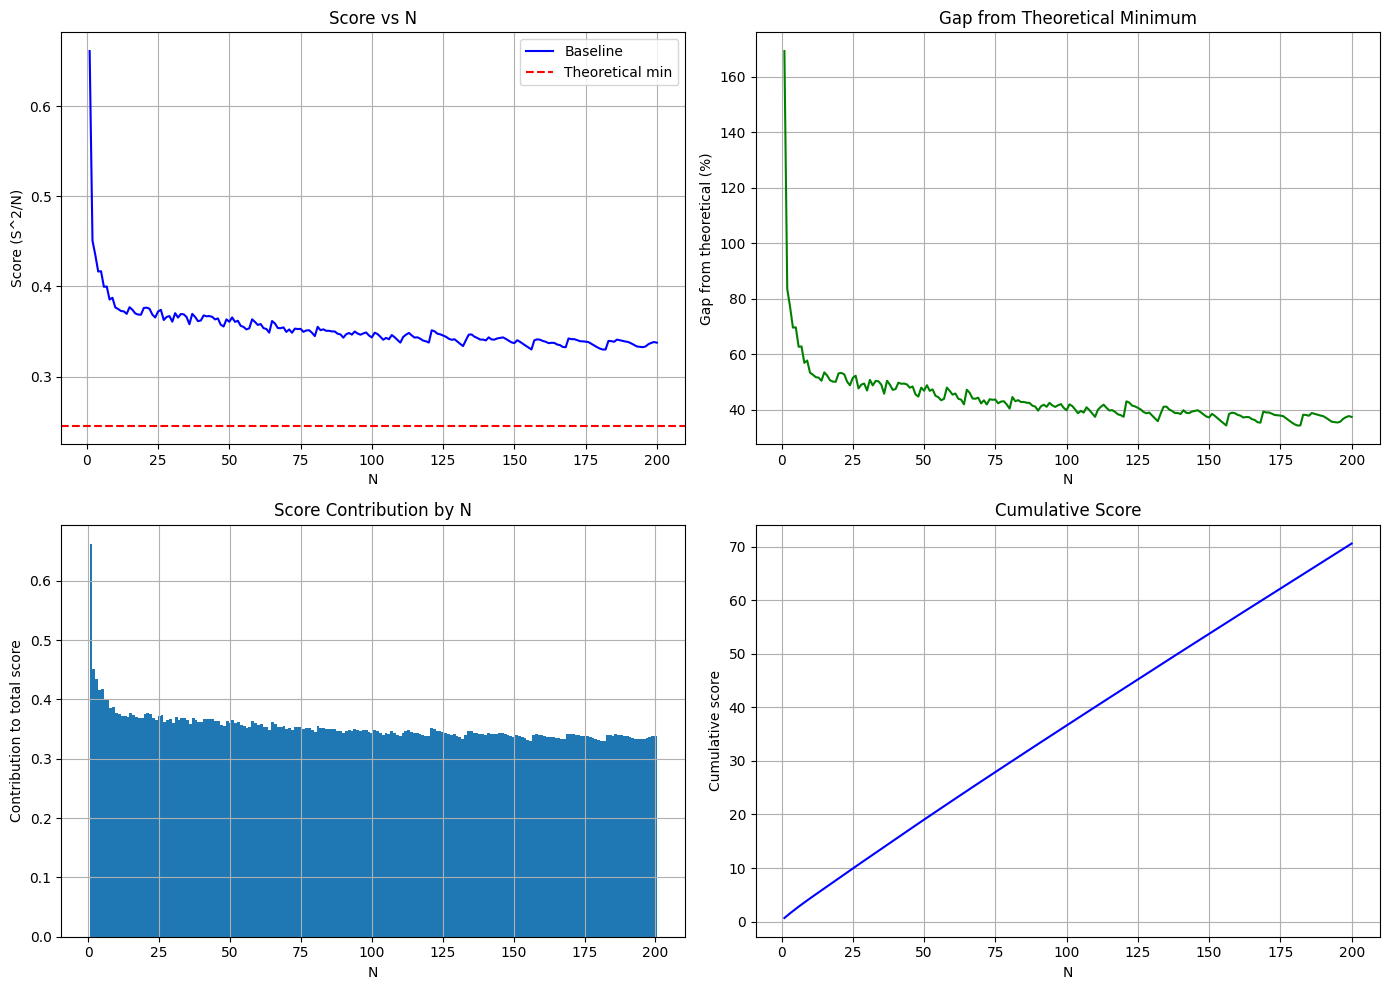


N values with highest gap from theoretical:
  N=1: gap=169.21%, score=0.661250
  N=2: gap=83.52%, score=0.450779
  N=3: gap=77.00%, score=0.434745
  N=5: gap=69.71%, score=0.416850
  N=4: gap=69.59%, score=0.416545
  N=7: gap=62.81%, score=0.399897
  N=6: gap=62.69%, score=0.399610
  N=9: gap=57.73%, score=0.387415
  N=8: gap=56.91%, score=0.385407
  N=15: gap=53.47%, score=0.376949

N values with lowest gap from theoretical:
  N=194: gap=35.57%, score=0.332999
  N=167: gap=35.51%, score=0.332835
  N=179: gap=35.41%, score=0.332591
  N=195: gap=35.40%, score=0.332576
  N=168: gap=35.36%, score=0.332475
  N=155: gap=35.19%, score=0.332069
  N=180: gap=34.76%, score=0.331000
  N=182: gap=34.35%, score=0.329988
  N=156: gap=34.35%, score=0.329986
  N=181: gap=34.33%, score=0.329945


In [7]:
# Analyze per-N scores and identify where the biggest gaps from theoretical are
import matplotlib.pyplot as plt

n_values = [r['n'] for r in all_results]
baseline_scores = [r['baseline_score'] for r in all_results]
theoretical_scores = [tree_area] * 200  # Same for all N

# Calculate gap percentage for each N
gaps = [(b - tree_area) / tree_area * 100 for b in baseline_scores]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score vs N
ax1 = axes[0, 0]
ax1.plot(n_values, baseline_scores, 'b-', label='Baseline')
ax1.axhline(y=tree_area, color='r', linestyle='--', label='Theoretical min')
ax1.set_xlabel('N')
ax1.set_ylabel('Score (S^2/N)')
ax1.set_title('Score vs N')
ax1.legend()
ax1.grid(True)

# Gap percentage vs N
ax2 = axes[0, 1]
ax2.plot(n_values, gaps, 'g-')
ax2.set_xlabel('N')
ax2.set_ylabel('Gap from theoretical (%)')
ax2.set_title('Gap from Theoretical Minimum')
ax2.grid(True)

# Contribution to total score
contributions = baseline_scores  # Each N contributes its score
ax3 = axes[1, 0]
ax3.bar(n_values, contributions, width=1)
ax3.set_xlabel('N')
ax3.set_ylabel('Contribution to total score')
ax3.set_title('Score Contribution by N')
ax3.grid(True)

# Cumulative contribution
cumulative = np.cumsum(contributions)
ax4 = axes[1, 1]
ax4.plot(n_values, cumulative, 'b-')
ax4.set_xlabel('N')
ax4.set_ylabel('Cumulative score')
ax4.set_title('Cumulative Score')
ax4.grid(True)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop14_score_analysis.png', dpi=100)
plt.show()

# Find N values with highest gaps
print("\nN values with highest gap from theoretical:")
gap_data = list(zip(n_values, gaps, baseline_scores))
gap_data.sort(key=lambda x: -x[1])
for n, gap, score in gap_data[:10]:
    print(f"  N={n}: gap={gap:.2f}%, score={score:.6f}")

print("\nN values with lowest gap from theoretical:")
for n, gap, score in gap_data[-10:]:
    print(f"  N={n}: gap={gap:.2f}%, score={score:.6f}")

In [8]:
# Investigate N=1 - this has the highest gap from theoretical\n# For N=1, the score is S^2/1 = S^2 where S is the bounding box side\n\n# Load N=1 solution\ntrees_x, trees_y, trees_angle = load_n(df, 1)\nprint(f\"N=1 solution:\")\nprint(f\"  x={trees_x[0]:.10f}\")\nprint(f\"  y={trees_y[0]:.10f}\")\nprint(f\"  angle={trees_angle[0]:.10f}\")\n\n# Calculate bounding box\nvx, vy = get_tree_vertices(trees_x[0], trees_y[0], trees_angle[0])\nmin_x, max_x = min(vx), max(vx)\nmin_y, max_y = min(vy), max(vy)\nwidth = max_x - min_x\nheight = max_y - min_y\nside = max(width, height)\n\nprint(f\"\\nBounding box:\")\nprint(f\"  width={width:.10f}\")\nprint(f\"  height={height:.10f}\")\nprint(f\"  side={side:.10f}\")\nprint(f\"  score={side**2:.10f}\")\n\n# The tree has dimensions roughly 0.7 wide x 1.0 tall\n# At 0 degrees, the bounding box is 0.7 x 1.0\n# At 45 degrees, the tree is rotated and the bounding box changes\n\n# Let's find the optimal angle for N=1\nangles = np.linspace(0, 360, 3601)  # 0.1 degree resolution\nscores = []\n\nfor angle in angles:\n    vx, vy = get_tree_vertices(0, 0, angle)\n    width = max(vx) - min(vx)\n    height = max(vy) - min(vy)\n    side = max(width, height)\n    scores.append(side**2)\n\nbest_idx = np.argmin(scores)\nbest_angle = angles[best_idx]\nbest_score = scores[best_idx]\n\nprint(f\"\\nOptimal angle search (0.1 degree resolution):\")\nprint(f\"  Best angle: {best_angle:.1f} degrees\")\nprint(f\"  Best score: {best_score:.10f}\")\nprint(f\"  Current score: {side**2:.10f}\")\nprint(f\"  Improvement: {side**2 - best_score:.10f}\")"